<a href="https://colab.research.google.com/github/Ajay-user/ML-DL-RL-repo/blob/master/seq2seq/Spanish_to_English_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install "tensorflow-text==2.8.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.1 MB/s 
     |████████████████████████████████| 462 kB 61.3 MB/s 


In [247]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
import seaborn as sns

## Download and prepare the dataset

In [ ]:
url='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
directory = tf.keras.utils.get_file(origin=url, extract=True)

2654208/2638744 [==============================] - 0s 0us/step


In [ ]:
data_dir = pathlib.Path(directory).parent

In [ ]:
[item for item in data_dir.iterdir()]

[PosixPath('/root/.keras/datasets/spa-eng'),
 PosixPath('/root/.keras/datasets/spa-eng.zip')]

In [ ]:
[item for item in (data_dir/'spa-eng').iterdir()]

[PosixPath('/root/.keras/datasets/spa-eng/spa.txt'),
 PosixPath('/root/.keras/datasets/spa-eng/_about.txt')]

In [ ]:
file_path = data_dir/'spa-eng/spa.txt'

text = file_path.read_text(encoding='utf-8')

In [ ]:
text[:50]

'Go.\tVe.\nGo.\tVete.\nGo.\tVaya.\nGo.\tVáyase.\nHi.\tHola.\n'

In [ ]:
text.splitlines()[:5]

['Go.\tVe.', 'Go.\tVete.', 'Go.\tVaya.', 'Go.\tVáyase.', 'Hi.\tHola.']

In [ ]:
lines = text.splitlines()
pairs = [line.split('\t') for line in lines]
pairs[:10]

[['Go.', 'Ve.'],
 ['Go.', 'Vete.'],
 ['Go.', 'Vaya.'],
 ['Go.', 'Váyase.'],
 ['Hi.', 'Hola.'],
 ['Run!', '¡Corre!'],
 ['Run.', 'Corred.'],
 ['Who?', '¿Quién?'],
 ['Fire!', '¡Fuego!'],
 ['Fire!', '¡Incendio!']]

In [ ]:
# spansih words 
inp = [inp for targ, inp in pairs]

inp[:10]

['Ve.',
 'Vete.',
 'Vaya.',
 'Váyase.',
 'Hola.',
 '¡Corre!',
 'Corred.',
 '¿Quién?',
 '¡Fuego!',
 '¡Incendio!']

In [ ]:
# english words
targ = [targ for targ, inp in pairs]
targ[:10]

['Go.', 'Go.', 'Go.', 'Go.', 'Hi.', 'Run!', 'Run.', 'Who?', 'Fire!', 'Fire!']

In [ ]:
assert len(inp) == len(targ)

len(inp)

118964

In [ ]:
inp[-1]

'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.'

In [ ]:
targ[-1]

'If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.'

### Create dataset

In [ ]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64


dataset = tf.data.Dataset.from_tensor_slices((inp,targ)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_spanish_batch, sample_english_batch = next(iter(dataset))

for spa, eng in zip(sample_spanish_batch[:5],sample_english_batch[:5]):
  print('Spanish : ',spa.numpy().decode())
  print('English : ',eng.numpy().decode())
  print('..'*50)


Spanish :  Puedes confiar que él mantendrá su palabra.
English :  You can trust him to keep his word.
....................................................................................................
Spanish :  Siguieron comiendo como si nada hubiera pasado.
English :  They continued eating as if nothing had happened.
....................................................................................................
Spanish :  Ella no debería haber hecho semejante cosa.
English :  She should not have done such a thing.
....................................................................................................
Spanish :  Acabo de estar en la casa de mi tío.
English :  I've just been to my uncle's house.
....................................................................................................
Spanish :  Hazlo de esta manera.
English :  Do it this way.
....................................................................................................


### Preprocessing the data

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The tensorflow_text package contains a unicode normalize operation:

In [ ]:
# Unicode normalization example
example_text = tf.constant('¿Todavía está en casa?')
print(example_text.numpy())

# Split accecented characters.
tf_text.normalize_utf8(example_text, normalization_form='NFKD').numpy()

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'


b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'

In [ ]:
# Lowercase example
example_text = tf.constant('¿Todavía está en casa?')
print(example_text.numpy().decode())

tf.strings.lower(example_text).numpy().decode()


¿Todavía está en casa?


'¿todavía está en casa?'

In [ ]:
# removing punctuations except [a-z ?!.¿,]

import string

string.punctuation+'removing punctuations except [a-z ?!.¿,]'

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~removing punctuations except [a-z ?!.¿,]'

In [ ]:
example_text = tf.constant(string.punctuation+'removing punctuations except [a-z ?!.¿,]')
print(example_text.numpy().decode())

tf.strings.regex_replace(example_text, '[^a-z?!.¿,]', " ").numpy().decode()

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~removing punctuations except [a-z ?!.¿,]


'!          , .      ?           removing punctuations except  a z ?!.¿, '

In [ ]:
  # Add spaces around selected punctuation.
example_text = tf.constant('¿Todavía está en casa?')
print(example_text.numpy().decode())
tf.strings.regex_replace(example_text, '[?!.¿,]', r' \0 ').numpy().decode()

¿Todavía está en casa?


' ¿ Todavía está en casa ? '

In [ ]:
# Strip whitespace and join START & END token
example_text = tf.constant('¿Todavía está en casa?')
print(example_text.numpy().decode())

add_space = tf.strings.regex_replace(example_text, '[?!.¿,]', r' \0 ')
stripped=tf.strings.strip(add_space)
tf.strings.reduce_join(['[START]' ,stripped, '[END]'], separator=" ").numpy().decode()

¿Todavía está en casa?


'[START] ¿ Todavía está en casa ? [END]'

In [ ]:
def tf_lower_and_split_punct(text):
  normal = tf_text.normalize_utf8(text,'NFKD')
  lower = tf.strings.lower(normal)
  remove_punct = tf.strings.regex_replace(lower, '[^ a-z.?!,¿]', '')
  add_space = tf.strings.regex_replace(remove_punct,  '[.?!,¿]', r' \0 ')
  stripped = tf.strings.strip(add_space)
  return tf.strings.join(['[START]', text, '[END]'], separator=' ')

In [ ]:
max_vocab_size = 5000

spanish_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_size, standardize=tf_lower_and_split_punct)
english_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_size, standardize=tf_lower_and_split_punct)

In [ ]:
spanish_vectorizer.adapt(inp)
english_vectorizer.adapt(targ)

In [ ]:
spanish_vocab = np.array(spanish_vectorizer.get_vocabulary())
spanish_vocab[:20]

array(['', '[UNK]', '[START]', '[END]', 'de', 'que', 'a', 'Tom', 'la',
       'en', 'el', 'no', 'es', 'un', 'No', 'se', 'una', 'lo', 'Él', 'por'],
      dtype='<U19')

In [ ]:
english_vocab = np.array(english_vectorizer.get_vocabulary())
english_vocab[:20]

array(['', '[UNK]', '[START]', '[END]', 'I', 'to', 'the', 'Tom', 'a',
       'you', 'is', 'in', 'of', 'was', 'He', 'The', 'have', 'for', 'that',
       'my'], dtype='<U17')

In [ ]:
for spa, eng in zip(sample_spanish_batch[:2],sample_english_batch[:2]):
  print('Spanish : ',spa.numpy().decode())
  print('Tokens : ', spanish_vectorizer(spa).numpy())
  print('Inverse transform : ', spanish_vocab[spanish_vectorizer(spa).numpy()] )
  print('English : ',eng.numpy().decode())
  print('Tokens : ', english_vectorizer(eng).numpy())
  print('Inverse transform : ', english_vocab[english_vectorizer(eng).numpy()] )
  print('..'*50)


Spanish :  Puedes confiar que él mantendrá su palabra.
Tokens :  [   2  431 1168    5   54    1   23 1000    3]
Inverse transform :  ['[START]' 'Puedes' 'confiar' 'que' 'él' '[UNK]' 'su' 'palabra.' '[END]']
English :  You can trust him to keep his word.
Tokens :  [  2  31  57 638  60   5 301  20 959   3]
Inverse transform :  ['[START]' 'You' 'can' 'trust' 'him' 'to' 'keep' 'his' 'word.' '[END]']
....................................................................................................
Spanish :  Siguieron comiendo como si nada hubiera pasado.
Tokens :  [   2    1 1293   47   63   93  482  354    3]
Inverse transform :  ['[START]' '[UNK]' 'comiendo' 'como' 'si' 'nada' 'hubiera' 'pasado.'
 '[END]']
English :  They continued eating as if nothing had happened.
Tokens :  [   2   62 1836  485   54  105  231   52  506    3]
Inverse transform :  ['[START]' 'They' 'continued' 'eating' 'as' 'if' 'nothing' 'had'
 'happened.' '[END]']
.....................................................

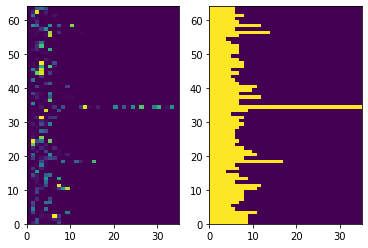

In [ ]:
sample_spanish_tokens = spanish_vectorizer(sample_spanish_batch)

plt.subplot(121)
plt.pcolormesh(sample_spanish_tokens)
# The returned token IDs are zero-padded. This can easily be turned into a mask:
plt.subplot(122)
plt.pcolormesh(sample_spanish_tokens!=0);

## The encoder/decoder model

In [ ]:
embedding_dim = 256
units = 1024

### The Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True, return_state=True)

  def call(self, inputs):
    word_vectors = self.embedding(inputs)
    sequences, state = self.gru(word_vectors)

    return sequences, state

In [ ]:
# lets test the encoder
spanish_vocab_size = spanish_vectorizer.vocabulary_size()

encoder = Encoder(spanish_vocab_size, embedding_dim, units)

In [ ]:
enc_rnn_output, enc_rnn_state = encoder(sample_spanish_tokens)

print('Shape of input spanish tokens', sample_spanish_tokens.shape)
print('Shape of encoder GRU output sequences', enc_rnn_output.shape)
print('Shape of encoder GRU state', enc_rnn_state.shape)

Shape of input spanish tokens (64, 35)
Shape of encoder GRU output sequences (64, 35, 1024)
Shape of encoder GRU state (64, 1024)


### The Attention

In [ ]:
class AttentionLayer(tf.keras.layers.Layer):
  def __init__(self, units):
    super(AttentionLayer, self).__init__()
    self.w1 = tf.keras.layers.Dense(units, use_bias=False)
    self.w2 = tf.keras.layers.Dense(units, use_bias=False)
    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, value_mask):
    self.query = self.w1(query)
    self.key = self.w2(value)
    self.query_mask = tf.ones(shape=tf.shape(query)[:-1], dtype=tf.bool)
    self.value_mask = value_mask
    context_vector, attention_weights = self.attention(inputs=[self.query,value,self.key],
                                                       mask=[self.query_mask, self.value_mask],
                                                       return_attention_scores=True)
    return context_vector, attention_weights   



In [ ]:
# lets test the attention
# attention needs query, value and value_mask

# The query: This will be generated by the decoder, later.
# The value: This Will be the output of the encoder.
# The mask: To exclude the padding, sample_spanish_tokens != 0


# Later, the decoder will generate this attention query
query_example = tf.random.normal(shape=[64,2,18])

attention = AttentionLayer(units)

context_vector, attention_score = attention(query_example, enc_rnn_output, sample_spanish_tokens!=0)


print('Shape of input spanish tokens, [the mask]', sample_spanish_tokens.shape)
print('Shape of encoder GRU output sequences, [the value]', enc_rnn_output.shape)
print('Shape of decoder output, [the query]', query_example.shape)
print('Shape of context vector', context_vector.shape)
print('Shape of attention score', attention_score.shape)


Shape of input spanish tokens, [the mask] (64, 35)
Shape of encoder GRU output sequences, [the value] (64, 35, 1024)
Shape of decoder output, [the query] (64, 2, 18)
Shape of context vector (64, 2, 1024)
Shape of attention score (64, 2, 35)


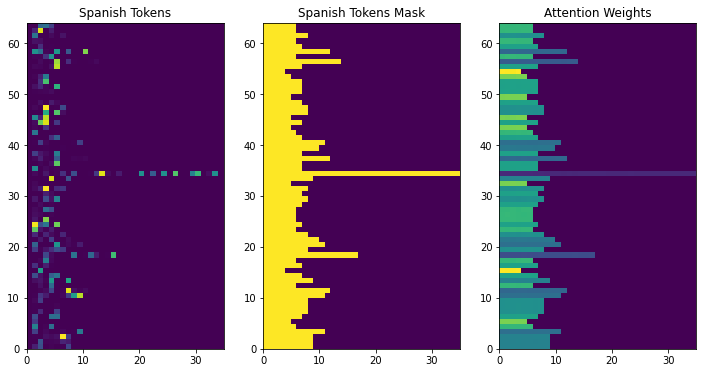

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(131)
plt.pcolormesh(sample_spanish_tokens)
plt.title('Spanish Tokens')

plt.subplot(132)
plt.pcolormesh(sample_spanish_tokens!=0)
plt.title('Spanish Tokens Mask')


plt.subplot(133)
plt.pcolormesh(attention_score[:,0,:])
plt.title('Attention Weights')

plt.show()

Because of the small-random initialization the attention weights are all close to 1/(sequence_length). If you zoom in on the weights for a single sequence, you can see that there is some small variation that the model can learn to expand, and exploit.

In [ ]:
attention_score[1, 0].numpy()

array([0.11142167, 0.11096146, 0.11147399, 0.11246412, 0.11132331,
       0.11090195, 0.10955202, 0.1105798 , 0.11132171, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

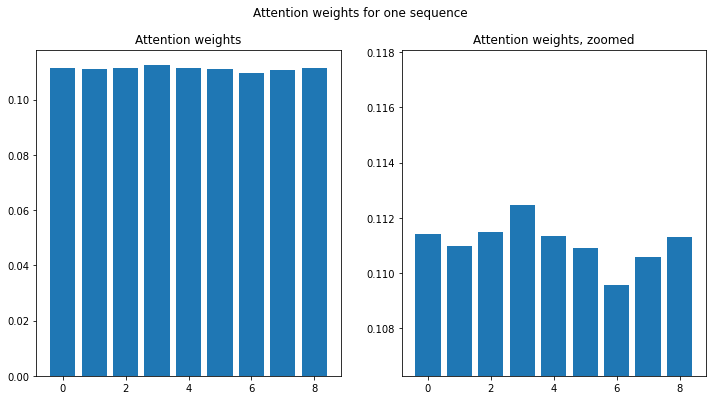

In [ ]:
attention_slice = attention_score[1, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]
plt.figure(figsize=(12,6))
ax1=plt.subplot(121)
plt.bar(np.arange(len(attention_slice)), attention_slice)
plt.title('Attention weights')

ax2=plt.subplot(122)
plt.bar(np.arange(len(attention_slice)), attention_slice)
top = max(ax1.get_ylim())
plt.ylim([top*0.9, top])
plt.title('Attention weights, zoomed')

plt.suptitle('Attention weights for one sequence')
plt.show()

### The Decoder
The decoder's job is to generate predictions for the next output token.

* The decoder receives the complete encoder output.
* It uses an RNN to keep track of what it has generated so far.
* It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.
* It combines the RNN output and the context vector to generate the "attention vector".
* It generates logit predictions for the next token based on the "attention vector".

In [ ]:

class Decoder(tf.keras.layers.Layer):
  def __init__(self,output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()

    self.embedding = tf.keras.layers.Embedding(output_vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
    self.attention = AttentionLayer(dec_units)
    self.ffnn = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh)
    self.output_layers = tf.keras.layers.Dense(output_vocab_size)

  def call(self, inputs_tokens, encoder_output, mask, previous_state=None):
    word_vectors = self.embedding(inputs_tokens)
    query_sequence, rnn_state_vector = self.gru(word_vectors, initial_state=previous_state)
    context_vector, attention_weights = self.attention(query_sequence, encoder_output, mask)
    context_and_meaning = tf.keras.layers.concatenate([context_vector, query_sequence])
    attention_vector = self.ffnn(context_and_meaning)
    logits = self.output_layers(attention_vector)
    return logits, attention_weights, rnn_state_vector


In [ ]:
# lets try the decoder
english_vocab_size = english_vectorizer.vocabulary_size()

decoder = Decoder(english_vocab_size, embedding_dim, units)

**The decoder takes 4 inputs.**

new_tokens - The last token generated. Initialize the decoder with the "[START]" token.

enc_rnn_output - Generated by the Encoder.

mask - A boolean tensor indicating where tokens != 0

**The state parameter in the call method of the decoder**<br>
state - The previous state output from the decoder (the internal state of the decoder's RNN). Pass None to zero-initialize it. The original paper initializes it from the encoder's final RNN state.

In [ ]:
sample_english_tokens = english_vectorizer(sample_english_batch)
start_index = english_vectorizer.get_vocabulary().index('[START]')
initial_english_token = tf.constant([[start_index]]*BATCH_SIZE)

logits, dec_attention_weights, dec_rnn_state = decoder(initial_english_token,
                                                       enc_rnn_output,
                                                       sample_spanish_tokens!=0,
                                                       enc_rnn_state)

In [ ]:
print('Shape of initial english token : ',initial_english_token.shape)
print('Shape of spanish tokens, [mask] : ',sample_spanish_tokens.shape)
print('Shape of encoder output, [key, value] : ',enc_rnn_output.shape)
print('Shape of logits output by decoder : ',logits.shape)
print('Shape of rnn state output by decoder : ',dec_rnn_state.shape)
print('Shape of attention weights output by decoder : ',dec_attention_weights.shape)


Shape of initial english token :  (64, 1)
Shape of spanish tokens, [mask] :  (64, 35)
Shape of encoder output, [key, value] :  (64, 35, 1024)
Shape of logits output by decoder :  (64, 1, 5000)
Shape of rnn state output by decoder :  (64, 1024)
Shape of attention weights output by decoder :  (64, 1, 35)


In [ ]:
# Sample a token according to the logits
sampled_tokens = tf.random.categorical(logits[:,0,:], num_samples=1)

In [ ]:
print('Shape of sampled tokens : ',sampled_tokens.shape)
english_vocab[sampled_tokens][:10]

Shape of sampled tokens :  (64, 1)


array([['sisters.'],
       ['green'],
       ['yen'],
       ['smelled'],
       ['pale.'],
       ['survive.'],
       ['documents.'],
       ['moving'],
       ['much.'],
       ['instead']], dtype='<U17')

Now use the decoder to generate a second set of logits.

* Pass the same enc_output and mask, these haven't changed.
* Pass the sampled token as new_tokens.
* Pass the decoder_state the decoder returned last time, so the RNN continues with a memory of where it left off last time.

In [ ]:
logits, dec_attention_weights, dec_rnn_state = decoder(sampled_tokens,
                                                       enc_rnn_output,
                                                       sample_spanish_tokens!=0,
                                                       dec_rnn_state)

In [ ]:
# Sample a token according to the logits
sampled_tokens = tf.random.categorical(logits[:,0,:], num_samples=1)
print('Shape of sampled tokens : ',sampled_tokens.shape)

english_vocab[sampled_tokens][:10]

Shape of sampled tokens :  (64, 1)


array([['fired'],
       ['flight'],
       ['else'],
       ['wallet'],
       ['sister'],
       ['attacked'],
       ['shelf.'],
       ['loan'],
       ['sight'],
       ['caught.']], dtype='<U17')

## Training the model
Now that you have all the model components, it's time to start training the model. You'll need:

* A loss function and optimizer to perform the optimization.
* A training step function defining how to update the model for each input/target batch.
* A training loop to drive the training and save checkpoints.

### Loss function

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self,):
    super(MaskedLoss, self).__init__()
    self.name='Masked loss'
    self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

  def call(self, y_true, y_preds):
    loss = self.loss_fn(y_true, y_preds)
    mask = tf.cast(y_true!=0, dtype=tf.float32)
    loss = loss*mask
    return tf.reduce_sum(loss)


### Implement the training step

Here the `train_step` method is a wrapper around the `_train_step` implementation which will come later. 

This wrapper includes a switch to turn on and off `tf.function` compilation, to make debugging easier.

In [ ]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, spanish_vectorizer, english_vectorizer, embedding_dim, units, use_tf_function=True):
    super(TrainTranslator, self).__init__()
    self.spanish_vectorizer=spanish_vectorizer
    self.english_vectorizer=english_vectorizer
    self.embedding_dim = embedding_dim
    self.units = units
    self.use_tf_function = use_tf_function

    self.encoder = Encoder(spanish_vectorizer.vocabulary_size(), embedding_dim, units)
    self.decoder = Decoder(english_vectorizer.vocabulary_size(), embedding_dim, units)


  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)
  

**Overall the implementation for the Model.train_step method is as follows:**

* Receive a batch of `input_text`, `target_text` from the `tf.data.Dataset`.
* Convert those raw text inputs to token-embeddings and masks.
* Run the encoder on the input_tokens to get the encoder_output and encoder_state.
* Initialize the decoder state and loss.
* Loop over the target_tokens:
* Run the decoder one step at a time.
* Calculate the loss for each step.
* Accumulate the average loss.
* Calculate the gradient of the loss and use the optimizer to apply updates to the model's `trainable_variables`.

#### _train_step

In [ ]:
def _train_step(self, inputs):
  spanish, english = inputs

  spanish_tokens = self.spanish_vectorizer(spanish)
  spanish_mask = spanish_tokens!=0
  english_tokens = self.english_vectorizer(english)
  english_mask = english_tokens!=0

  max_english_length = tf.shape(english_tokens)[1]

  # Gradient tape
  with tf.GradientTape() as tape:
    # encode the spanish words
    enc_rnn_output, enc_rnn_state = self.encoder(spanish_tokens)
    # initialize the decoder state
    dec_rnn_state = enc_rnn_state
    # initialize the loss-fn
    loss = tf.constant(0.0)

    for t in tf.range(max_english_length-1):
      # Pass in two tokens from the target sequence (ENGLISH): 
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = english_tokens[:,t:t+2]
      step_loss, dec_rnn_state = self._loop_step(new_tokens, enc_rnn_output, spanish_mask, dec_rnn_state)

      loss = loss + step_loss
    
    # Average the loss over all non padding tokens.
    average_loss = loss/tf.reduce_sum( tf.cast(english_mask, dtype=tf.float32))
    # trainable variables
    variables = self.trainable_variables
    # gradients
    gradients = tape.gradient(average_loss, variables)
    # Apply an optimization step
    self.optimizer.apply_gradients(zip(gradients, variables))
    
    # Return a dict mapping metric names to current value
    return {'batch_loss':average_loss}



TrainTranslator._train_step = _train_step

#### _loop_step

In [ ]:
def _loop_step(self, new_tokens, enc_rnn_output, spanish_mask, dec_rnn_state):
  inp_token, target_token = new_tokens[:,0:1], new_tokens[:,1:2]
  # decoder
  logits, attention_weights, dec_rnn_state = self.decoder(inp_token,
                                                          enc_rnn_output,
                                                          spanish_mask,
                                                          dec_rnn_state )
  # loss calulation
  step_loss = self.loss(target_token, logits)
  
  return step_loss, dec_rnn_state



TrainTranslator._loop_step = _loop_step


###  Test the training step

In [ ]:
translator = TrainTranslator(spanish_vectorizer,
                             english_vectorizer,
                             embedding_dim,
                             units,
                             use_tf_function=False)

# compile the model
translator.compile(optimizer='Adam', loss=MaskedLoss())

In [ ]:
# lets see the result 
# -- For a text model like this the loss should start near:np.log(output_text_processor.vocabulary_size())

np.log(english_vectorizer.vocabulary_size())

8.517193191416238

In [ ]:
%%time
for i in range(10):
  print(translator.train_step([sample_spanish_batch, sample_english_batch]))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5075827>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.479778>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.4254994>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.2594533>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.574415>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.8808026>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.70702>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.6517954>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.475112>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3173156>}
CPU times: user 9.35 s, sys: 181 ms, total: 9.53 s
Wall time: 9.72 s


### tf.function wrapper

While it's easier to debug without a `tf.function` it does give a performance boost.

 So now that the `_train_step` method is working, try the `tf.function` wrapped `_tf_train_step`, to maximize performance while training:

In [ ]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)


TrainTranslator._tf_train_step= _tf_train_step

In [ ]:
%%time
translator.use_tf_function=True

translator.train_step([sample_spanish_batch, sample_english_batch])

CPU times: user 4.44 s, sys: 189 ms, total: 4.63 s
Wall time: 4.3 s


In [ ]:
%%time
for i in range(10):
  print(translator.train_step([sample_spanish_batch, sample_english_batch]))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2445135>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2208033>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1478405>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.045743>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9668994>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9288094>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8986807>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8613176>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8185515>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7805922>}
CPU times: user 7.89 s, sys: 741 ms, total: 8.63 s
Wall time: 5.24 s


### history callback

In [ ]:
class BatchLoss(tf.keras.callbacks.Callback):
  def __init__(self, key):
    super(BatchLoss, self).__init__()
    self.key = key
    self.logs = []
  
  def on_train_batch_end(self, n , logs):
    self.logs.append(logs[self.key])



batch_loss = BatchLoss('batch_loss')

### Training

build a fresh copy of the model to train from scratch:

In [ ]:
train_translator = TrainTranslator(spanish_vectorizer,
                             english_vectorizer,
                             embedding_dim,
                             units,
                             use_tf_function=True)

# compile the model
train_translator.compile(optimizer='Adam', loss=MaskedLoss())

In [ ]:
%%time
history = train_translator.fit(dataset, epochs=3, callbacks=[batch_loss])

Epoch 1/3
1859/1859 [==============================] - 481s 255ms/step - batch_loss: 2.3553
Epoch 2/3
1859/1859 [==============================] - 461s 248ms/step - batch_loss: 1.2813
Epoch 3/3
1859/1859 [==============================] - 457s 246ms/step - batch_loss: 1.0290
CPU times: user 35min 15s, sys: 3min 43s, total: 38min 59s
Wall time: 24min 27s


Text(0, 0.5, 'CE/token')

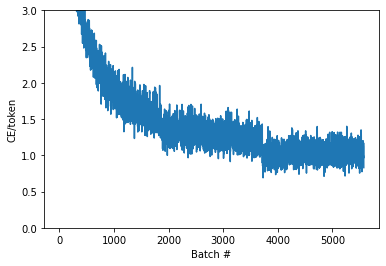

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

## Translate
Now that the model is trained, implement a function to execute the full text => text translation.


Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.

In [287]:
class Translate(tf.Module):
  def __init__(self, spanish_vectorizer, english_vectorizer, encoder, decoder):
    self.encoder = encoder
    self.decoder = decoder
    self.spanish_vectorizer = spanish_vectorizer
    self.english_vectorizer = english_vectorizer
    
    self.id_to_string = tf.keras.layers.StringLookup(vocabulary=english_vectorizer.get_vocabulary(),
                                                     mask_token='', 
                                                     invert=True)
    
    self.string_to_id = tf.keras.layers.StringLookup(vocabulary=english_vectorizer.get_vocabulary(),
                                                     mask_token='')
    
    to_mask = self.string_to_id(['', '[UNK]', '[START]'])
    token_mask = np.zeros(shape=len(english_vectorizer.get_vocabulary()), dtype=bool)
    token_mask[to_mask.numpy()]=True
    self.token_mask = token_mask

    self.start_token = self.string_to_id('[START]')
    self.end_token = self.string_to_id('[END]')



In [288]:
# instantization
translator = Translate(spanish_vectorizer, english_vectorizer,
                       train_translator.encoder, train_translator.decoder)

### Convert token IDs to text

In [289]:
# Convert token IDs to text
def tokens_to_text(self, tokens):
  text = self.id_to_string(tokens)
  text = tf.strings.reduce_join(text, separator=' ', axis=-1)
  return tf.strings.strip(text)

Translate.tokens_to_text = tokens_to_text

In [290]:
# lets test this 

# shape of tokens = [batch, n]

example_tokens = tf.random.uniform(shape=[5,2], maxval=english_vectorizer.vocabulary_size(), dtype=tf.int32)

translator.tokens_to_text(example_tokens).numpy()

array([b'classmates. covered', b'granted smiled.', b'painting. kids?',
       b'drop 30', b'gun scream.'], dtype=object)

### Sample from logits

In [291]:
def sample(self, logits, temperature):
  mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  logits = tf.where(mask, -np.inf, logits)

  if temperature == 0.0:
    return tf.argmax(logits, axis=-1)
  else:
    logits = logits/temperature
    logits = tf.squeeze(logits, axis=1)
    return tf.random.categorical(logits, num_samples=1)
  
Translate.sample = sample

In [292]:
# lets test this 
# shape of logits [batch, query, vocab-size]
example_logits = tf.random.normal(shape=[5, 1, 5000])
print('tempearature=0',translator.sample(example_logits, temperature=0))
print('tempearature=1',translator.sample(example_logits, temperature=1))
print('tempearature=2',translator.sample(example_logits, temperature=2))

tempearature=0 tf.Tensor(
[[1034]
 [1027]
 [ 716]
 [3412]
 [2206]], shape=(5, 1), dtype=int64)
tempearature=1 tf.Tensor(
[[3762]
 [2718]
 [4019]
 [ 117]
 [1826]], shape=(5, 1), dtype=int64)
tempearature=2 tf.Tensor(
[[4775]
 [3739]
 [4709]
 [3737]
 [4926]], shape=(5, 1), dtype=int64)


### Implement the translation loop

This implementation statically unrolls the graph out to max_length iterations. This is okay with eager execution in python.

In [293]:
def translate_unrolled(self, input_text, max_length=50, temperature=1.0):

  spanish_tokens = self.spanish_vectorizer(input_text)
  spanish_mask = spanish_tokens!=0

  enc_rnn_output, enc_state = self.encoder(spanish_tokens)

  # initialize the decoder state
  dec_state = enc_state

  # initialize the new tokens with '[START]' token_id
  batch_size = tf.shape(input_text)[0]
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  result_tokens, attention_scores = [], []

  # loop
  for i in range(max_length):
    # inputs_tokens, encoder_output, mask, previous_state
    logits, attention_weights, dec_state = self.decoder(new_tokens,
                                                        enc_rnn_output,
                                                        spanish_mask,
                                                        dec_state)
    
    new_tokens = self.sample(logits, temperature)

    done = done | (new_tokens==self.end_token)
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    result_tokens.append(new_tokens)
    attention_scores.append(attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  
  # now lets convert id to text
  result_tokens = tf.concat(result_tokens, axis=-1)
  text_translation = self.tokens_to_text(result_tokens)

  # concat attention weights [ TensorShape([64, 1, 35]), TensorShape([64, 1, 35]) , ... ]
  # ex : [ TensorShape([64, 1, 35]), .... ] ==> TensorShape([64, i, 35])
  attention_scores = tf.concat(attention_scores, axis=1)

  return text_translation, attention_scores


Translate.translate_unrolled = translate_unrolled

### Running on a simple input:

In [294]:

%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

text_translation, attention_scores = translator.translate_unrolled(
    input_text = input_text)


CPU times: user 301 ms, sys: 16.2 ms, total: 317 ms
Wall time: 243 ms


In [295]:
print(text_translation.numpy())

[b"It's much Greek call." b'This is my life.']


In [296]:
print('shape of attention scores',attention_scores.shape)

shape of attention scores (2, 5, 6)


### Wrap inside tf.function

* The resulting graphs are very large and take a few seconds to build, save or load.
* You can't break from a statically unrolled loop, so it will always run max_length iterations, even if all the outputs are done. But even then it's marginally faster than eager execution.

In [297]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, inputs):
  return self.translate_unrolled(inputs)


Translate.tf_translate = tf_translate

Run the tf.function once to compile it:

In [298]:
%%time
text_translation, attention_scores = translator.tf_translate(input_text)


CPU times: user 21 s, sys: 401 ms, total: 21.4 s
Wall time: 21.4 s


In [299]:
%%time
text_translation, attention_scores = translator.tf_translate(input_text)
print(text_translation.numpy())
print('shape of attention scores',attention_scores.shape)

[b"It's big bad luck to think about us." b'This is my life.']
shape of attention scores (2, 50, 6)
CPU times: user 149 ms, sys: 10.6 ms, total: 159 ms
Wall time: 127 ms


### Symbolic loop

The initial implementation used python lists to collect the outputs.

This uses `tf.range` as the loop iterator, allowing `tf.autograph` to convert the loop. The biggest change in this implementation is the use of `tf.TensorArray` instead of python list to accumulate tensors.

`tf.TensorArray` is required to collect a variable number of tensors in graph mode.

With eager execution this implementation performs on par with the original:

In [313]:
def translate_symbolic(self, input_text, max_length=50, temperature=1.0):
  
  spanish_tokens = self.spanish_vectorizer(input_text)
  spanish_mask = spanish_tokens!=0
  
  enc_rnn_output, enc_state = self.encoder(spanish_tokens)
  dec_state = enc_state

  batch_size = tf.shape(input_text)[0]
  new_tokens = tf.fill([batch_size,1], self.start_token)

  done = tf.zeros([batch_size,1], dtype=tf.bool)

  result_tokens = tf.TensorArray(dtype=tf.int64, size=1, dynamic_size=True)
  attention_score = tf.TensorArray(dtype=tf.float32, size=1, dynamic_size=True)

  for i in tf.range(max_length):

     logits, attention_weights, dec_state = self.decoder(new_tokens,
                                                        enc_rnn_output,
                                                        spanish_mask,
                                                        dec_state)
     

     new_tokens = self.sample(logits, temperature)
     done = done|(new_tokens==self.end_token)
     new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
     
     result_tokens = result_tokens.write(i, new_tokens)
     attention_score = attention_score.write(i, attention_weights)

     if tf.reduce_all(done):
       break

    
  
  result_tokens = result_tokens.stack()
  # shape ==> [i , batch, tq]  ; tq=1
  result_tokens = tf.squeeze(result_tokens, axis=-1)
  # shape ==> [i , batch, 1] to [i, batch]
  result_tokens = tf.transpose(result_tokens, [1, 0])
  # shape ==> [i , batch] to [batch, i]
  text_translation = self.tokens_to_text(result_tokens)
  # shape ==> [batch, i] to [batch]
  

  attention_score = attention_score.stack()
  # shape ==> [i , batch, tq, tv]  ; tq=1
  attention_score = tf.squeeze(attention_score,axis=2)
  # shape ==> [i , batch, tq, tv] = [i , batch, tv]
  attention_score = tf.transpose(attention_score, [1,0,2])
  # shape ==> [i , batch, tq, tv] = [batch, i , tv]
  # ex : TensorShape([i, 64, 1, 35]) ==> TensorShape([64, i, 35])


  return text_translation, attention_score

    

Translate.translate_symbolic = translate_symbolic

In [314]:
%%time
# lets test this 
text_translation, attention_scores = translator.translate_symbolic(input_text)
print(text_translation.numpy())
print('shape of attention scores',attention_scores.shape)

[b'This is my life.' b'Are they still at home?'
 b'Stop pretending with it.']
shape of attention scores (3, 6, 6)
CPU times: user 90.8 ms, sys: 1.78 ms, total: 92.6 ms
Wall time: 91 ms


But when you wrap it in a tf.function you'll notice two differences.

First: Graph creation is much faster (~10x), since it doesn't create max_iterations copies of the model.


Second: The compiled function is much faster on small inputs (5x on this example), because it can break out of the loop.




In [315]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate_symbolic(self, inputs):
  return self.translate_symbolic(inputs)

Translate.tf_translate_symbolic = tf_translate_symbolic

In [316]:
%%time
# lets test this  --- compile time
text_translation, attention_scores = translator.tf_translate_symbolic(input_text)
print(text_translation.numpy())
print('shape of attention scores',attention_scores.shape)

[b'This is my life.' b'Are kept at home now?' b'We Think about energy.']
shape of attention scores (3, 6, 6)
CPU times: user 890 ms, sys: 21.5 ms, total: 911 ms
Wall time: 896 ms


In [317]:
%%time
# lets test this  ---- after compile
text_translation, attention_score = translator.tf_translate_symbolic(input_text)
print(text_translation.numpy())
print('shape of attention scores',attention_scores.shape)

[b'This is my life.' b'Are you coming home?'
 b'You get tried out from behind.']
shape of attention scores (3, 6, 6)
CPU times: user 34.3 ms, sys: 3.44 ms, total: 37.8 ms
Wall time: 29 ms


## Visualize the process
The attention weights returned by the translate method show where the model was "looking" when it generated each output token.

So the sum of the attention over the input should return all ones:

In [318]:
print('shape of attention scores',attention_scores.shape)

shape of attention scores (3, 6, 6)


In [353]:
def get_attributes(input_text, text_translation, attention_scores, index):
    y_true = tf_lower_and_split_punct(input_text[index]).numpy().decode().split()
    y_pred = text_translation[index].numpy().decode().split()+['[END]']

    score = attention_scores[index]
    score = score[:len(y_pred),:len(y_true)]

    return y_true, y_pred, score

def matplot_imshow(y_true, y_pred, score):
    plt.imshow(score)
    plt.yticks(range(len(y_pred)),y_pred)
    plt.xticks(range(len(y_true)),y_true);


def seaborn_heatmap(y_true, y_pred, score):
  sns.heatmap(score, annot=True)
  plt.yticks(range(len(y_pred)),y_pred, rotation=360)
  plt.xticks(range(len(y_true)),y_true);

def visualize(input_text, text_translation, attention_scores,figsize=(12,6), index=0):

  y_true, y_pred, score = get_attributes(input_text, text_translation, attention_scores, index)

  plt.figure(figsize=figsize)

  plt.subplot(121)
  matplot_imshow(y_true, y_pred, score)

  plt.subplot(122)
  seaborn_heatmap(y_true, y_pred, score)

  plt.show()

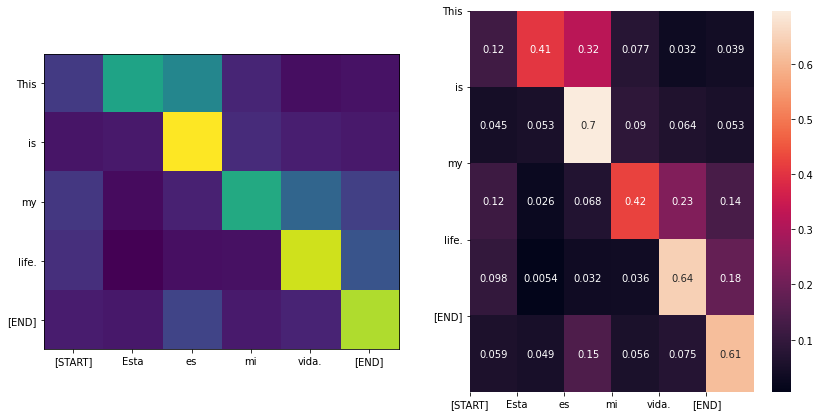

In [320]:
visualize(input_text, text_translation, attention_scores, figsize=(14,7), index=0)

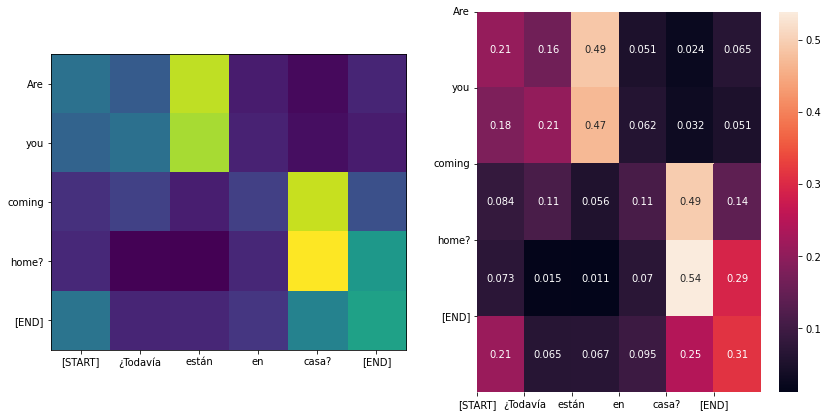

In [321]:
visualize(input_text, text_translation, attention_scores, figsize=(14,7), index=1)

### Example 

In [373]:
%%time
input_text = tf.constant([
    # This is my life.
    'Esta es mi vida.',
    # Are they still home?
    '¿Todavía están en casa?',
    # Try to find out.'
    'Tratar de descubrir.',
])


text_translation, attention_scores = translator.tf_translate_symbolic(input_text)
print(text_translation.numpy())
print('shape of attention scores',attention_scores.shape)

[b'This is my life life.' b'Are you still at home?'
 b'We tried to repeat it.']
shape of attention scores (3, 6, 6)
CPU times: user 32.2 ms, sys: 4.26 ms, total: 36.5 ms
Wall time: 25.3 ms


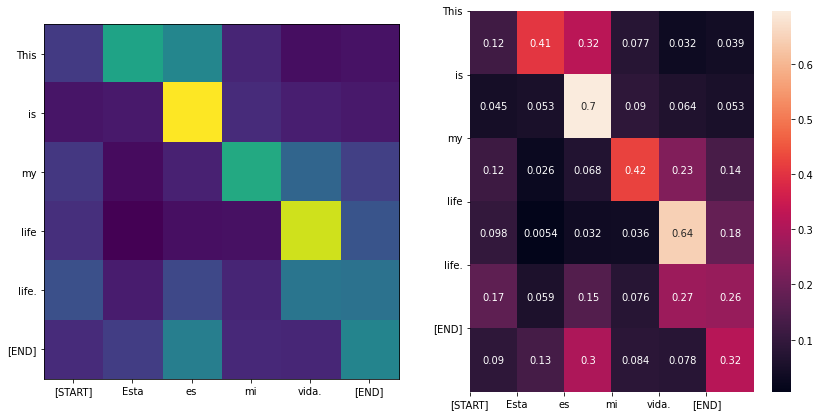

In [374]:
visualize(input_text, text_translation, attention_scores, figsize=(14,7), index=0)

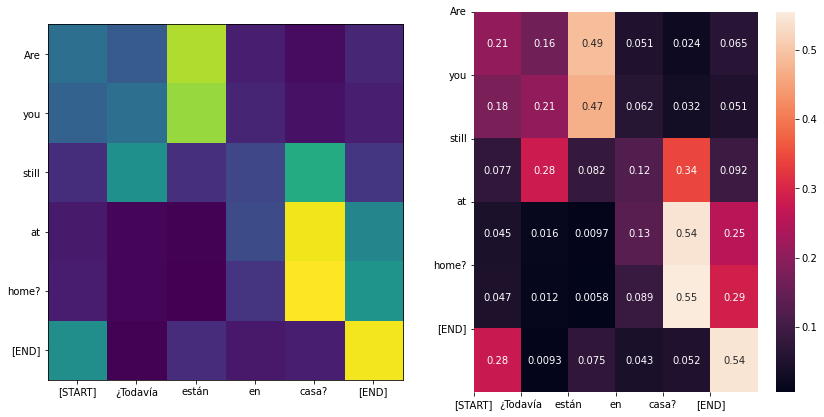

In [375]:
visualize(input_text, text_translation, attention_scores, figsize=(14,7), index=1)

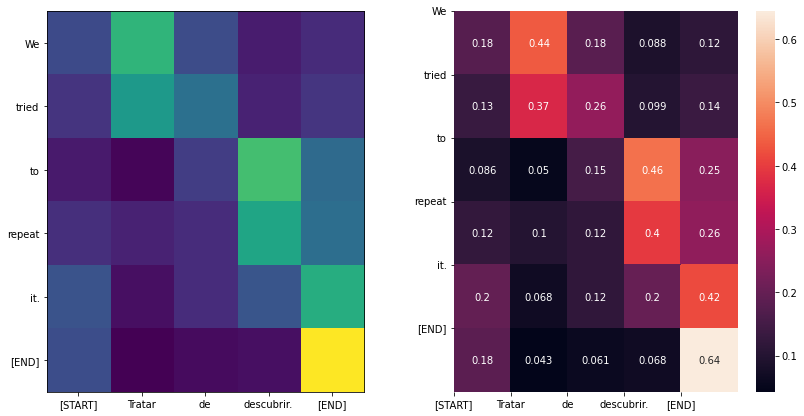

In [376]:
visualize(input_text, text_translation, attention_scores, figsize=(14,7), index=2)

## Limitations

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

* The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.

* The model only has access to its previous output through the RNN state. If the RNN state gets corrupted, there's no way for the model to recover. Transformers solve this by using self-attention in the encoder and decoder.

In [358]:
# long sentence -- spanish
inp[-1]

'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.'

In [359]:
# target english 
targ[-1]

'If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.'

In [360]:
input_text = tf.constant([inp[-1]])
text_translation, attention_scores = translator.tf_translate_symbolic(input_text)
print(text_translation.numpy())
print('shape of attention scores',attention_scores.shape)

[b'If you want to sound like a native understanding what you can be willing to tell me the same way to and it moved over and over and another over and over over the same and over it said over it boys and here go to go and him in']
shape of attention scores (1, 50, 51)


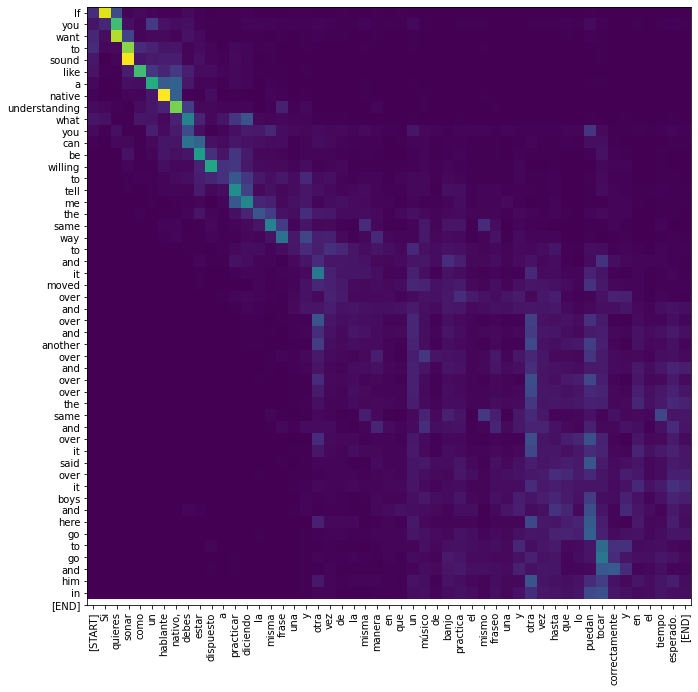

In [367]:
# visulize
y_true, y_pred, score = get_attributes(input_text, text_translation, attention_scores, index=0)

plt.figure(figsize=(22,11))
matplot_imshow(y_true, y_pred, score)
plt.xticks(rotation=90)
plt.show()